# EasyVisa Project

## Context:

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

## Objective:

In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. The objective is to analyze the data provided and, with the help of a classification model:

* Facilitate the process of visa approvals.
* Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status. 


## Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent of the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y= Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No 
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer's company was established
* region_of_employment: Information of foreign worker's intended region of employment in the US.
* prevailing_wage:  Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment. 
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
* case_status:  Flag indicating if the Visa was certified or denied

## Importing necessary libraries and data

In [1]:
#conda install -c conda-forge xgboost

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd  

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [3]:
#Loading dataset
data=pd.read_csv("EasyVisa.csv")

## Data Overview

- Observations
- Sanity checks

In [4]:
#View the 1st 5 rows of dataset
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [5]:
#Check data type and not null values for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [6]:
data.shape

(25480, 12)

- There are 25480 rows and 12 columns in the data set
- There are no missing values in the data set. This can be verified by isna() method 
- Number of employees, years of establishment & prevailing wages are of type integer or float. All other attributes are of object type and will need to be converted to the right datatype

In [7]:
data.isna().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

 - There are no missing values in the dataset

In [8]:
cols = data.select_dtypes(['object'])
cols.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'region_of_employment', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [9]:
for i in cols.columns:
    data[i] = data[i].astype('category')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  category
 1   continent              25480 non-null  category
 2   education_of_employee  25480 non-null  category
 3   has_job_experience     25480 non-null  category
 4   requires_job_training  25480 non-null  category
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  category
 8   prevailing_wage        25480 non-null  float64 
 9   unit_of_wage           25480 non-null  category
 10  full_time_position     25480 non-null  category
 11  case_status            25480 non-null  category
dtypes: category(9), float64(1), int64(2)
memory usage: 2.0 MB


- All datatypes of object type have been coverted to category. The memory usage has also decreased from 2.3+MB to 2MB

### Summary of dataset

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


- The average number of employees in the employer's organization are 5667 while the median number of employees in the employer's organization are 2109. This implies the attribute has a right skewed distribution with several positive outliers. The minimum number is negative which does not appear to be a valid data point
- There are companies in the dataset with years of establishment from 1800 to 2016
- The average prevailing wage for occupation is united states is USD 74,455 while the median (~50th percentile of wages) is USD 70,308. This indicates, slight right skewness in the data set. The minimum value of USD 2.1367 does not appear to be a valid data point. The attribute has to be studied in union with unit_of_wage to gather further insight

In [12]:
data.describe(include=['category']).T

,count,unique,top,freq
case_id,25480,25480,EZYV01,1
continent,25480,6,Asia,16861
education_of_employee,25480,4,Bachelor's,10234
has_job_experience,25480,2,Y,14802
requires_job_training,25480,2,N,22525
region_of_employment,25480,5,Northeast,7195
unit_of_wage,25480,4,Year,22962
full_time_position,25480,2,Y,22773
case_status,25480,2,Certified,17018


- The case ID attribute can be dropped as it is a unique ID variable and is not expected to add any value to the status of a visa being accepted
- There are 6 continents in the database, with majority of applicants from Asia
- There are 4 different levels of eduction with Bachelor's being the highest education degree for majority of applicants
- Majority of applicants do not require further job training to perform the intended occupation in the US
- There are 5 different regions in the US requiring immigrants due to Human Resource shortages, the maximum being in the NorthEast US region
- There are 4 different units of wages with yearly being the most common. The prevailing wage and unit of wage may need to be studied in union to gather further insight
- Majority of the occupation with employee shortages are full time positions
- Case status is the attribute of interest (which needs to be predicted by our ML model). As per dataset, 66.7% of all applicants have a certified visa status and only 33.2% have a denied visa status

In [13]:
data.drop(['case_id'],axis=1,inplace=True)

In [14]:
data[data.duplicated()].count()

continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

-  There are no repeat data entries in the dataset that will need further cleaning

## Exploratory Data Analysis (EDA)

### Univariate analysis

In [15]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [16]:
#Observations on number_of_employees

#Removing negative entries for no_of_employees
data.drop(data[(data["no_of_employees"]<=0)].index, inplace=True)

In [17]:
data.shape

(25447, 11)

- This removed thirty-three entries from the dataset

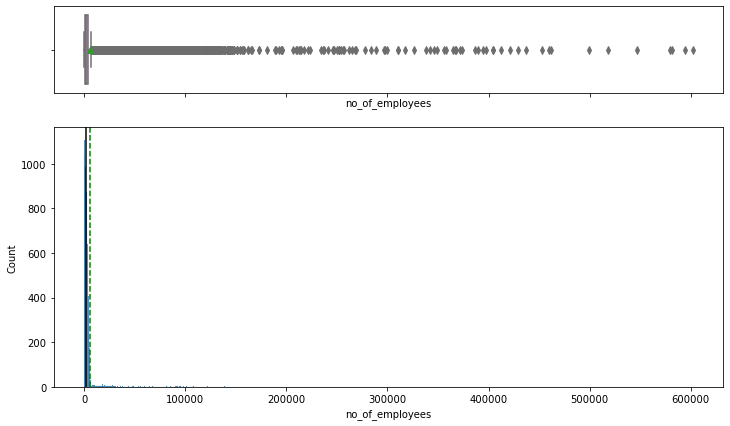

In [18]:
histogram_boxplot(data, "no_of_employees")

- The distribution for number of employees for employers is heavily skewed right

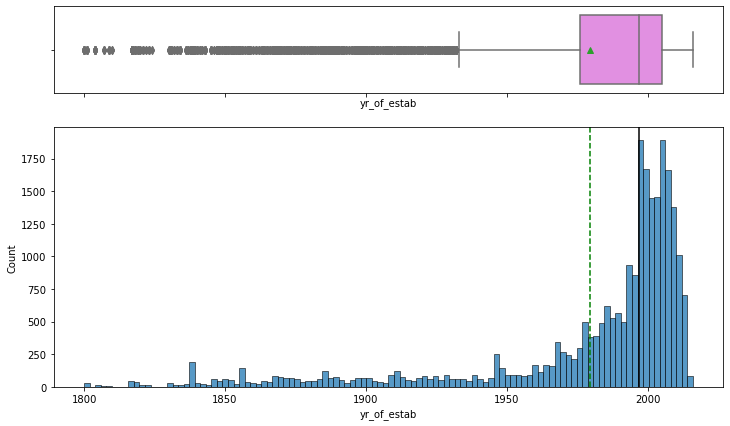

In [19]:
#Observations on year_of_establishment
histogram_boxplot(data, "yr_of_estab")

- The distribution for year established is skewed left

In [20]:
#Observations on prevailing_wage and unit_of_wage

In [21]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

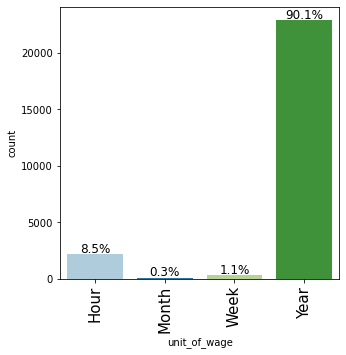

In [22]:
labeled_barplot(data, "unit_of_wage", perc=True);

- Almost 90% of all entries are with unit_of_wage as yearly and only 8.5% entries as hourly. Negligible entries are on a monthly and weekly basis (which requires further investigation)

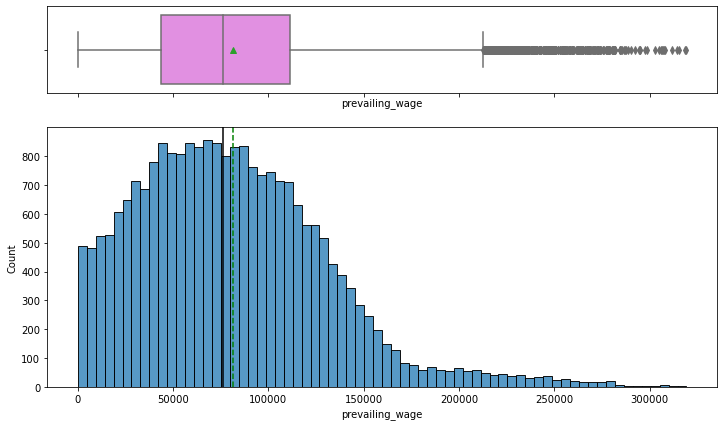

In [23]:
#Observations specifically on data where unit_of_wage is yearly
histogram_boxplot(data[(data["unit_of_wage"]=="Year")], "prevailing_wage")

- The average and median annual salary is approx. USD 70,000 which seems accurate
- The trend appears correct with outliers in the higher income bracket between USD 200,000 to USD 300,000
- There are several very low salaries as well, which appears incorrect and requires further investigation

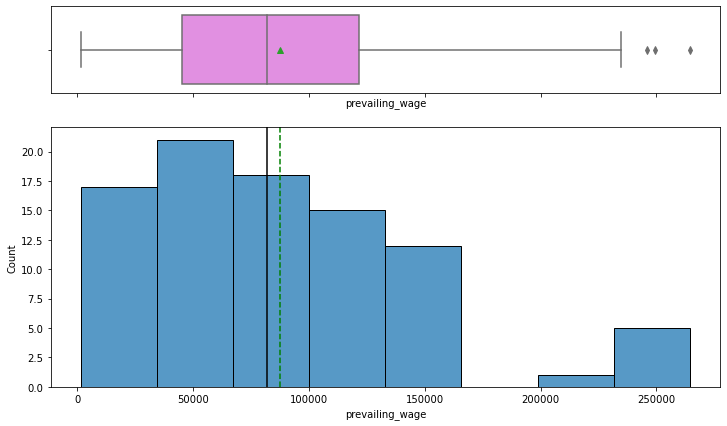

In [24]:
#Observations specifically on data where unit_of_wage is weekly or monthly
histogram_boxplot(data[(data["unit_of_wage"]=="Month")], "prevailing_wage")

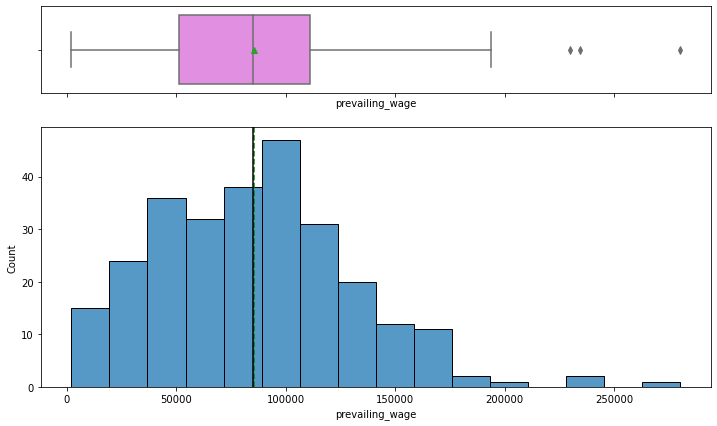

In [25]:
histogram_boxplot(data[(data["unit_of_wage"]=="Week")], "prevailing_wage")

- Based on the data we see above, we can infer that prevailing_wages is likely already a yearly salary where unit_of_wage is either weekly or monthly

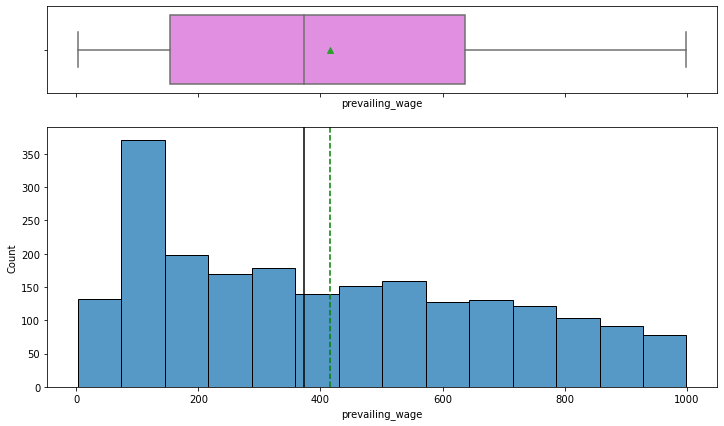

In [26]:
#Observations specifically on data where unit_of_wage is hourly 
histogram_boxplot(data[data["unit_of_wage"]=="Hour"], "prevailing_wage")

- Based on the data we see above, we can infer that the prevailing_wage is likely a weekly salary where unit_of_wage is hourly. 
(We make this assumption as a median rate of pay of USD 400 per hour appears incorrect.)

#### It can be infered that the dataset is very unclean.
- "prevailing_wages" will be cleaned up to contain only wages on an annual basis, so it is uniform and can be used for model building
- "unit_wages" is assumed to be:
    - Not-Hourly, when the employee is paid a fixed salary (irrespective of the number of hours worked). We will consider any unit_of_wages inherently as weekly, monthly or yearly as Not-Hourly
    - Hourly, when the employee is paid depending on the number of hours worked. We will consider any unit_of_wages inherently as hourly as hourly

In [27]:
data.loc[data["unit_of_wage"]=="Hour", "prevailing_wage"] = \
data.loc[data["unit_of_wage"]=="Hour", "prevailing_wage"]*52
# assuming 52 paid weeks per year

In [28]:
data["unit_of_wage"] = data["unit_of_wage"].astype('object')
data.loc[data["unit_of_wage"]=="Hour", "unit_of_wage"] = "Hourly"
data.loc[data["unit_of_wage"]=="Week", "unit_of_wage"] = "Not_Hourly"
data.loc[data["unit_of_wage"]=="Month", "unit_of_wage"] = "Not_Hourly"
data.loc[data["unit_of_wage"]=="Year", "unit_of_wage"] = "Not_Hourly"
data["unit_of_wage"] = data["unit_of_wage"].astype('category')

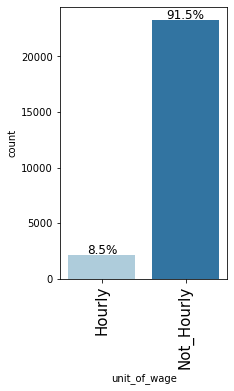

In [29]:
labeled_barplot(data, "unit_of_wage", perc=True)

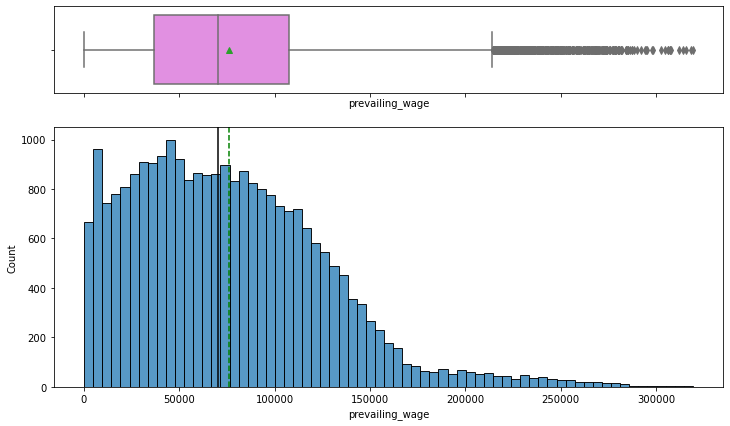

In [30]:
histogram_boxplot(data, "prevailing_wage")

- There are still several lower and upper end outlier in annual_prevailing_wages which requires further investigation

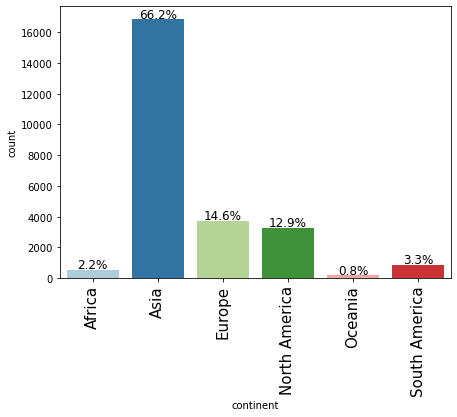

In [31]:
#Observations on continent
labeled_barplot(data, "continent", perc=True)

- Majority of employees (>50%) are from Asia 

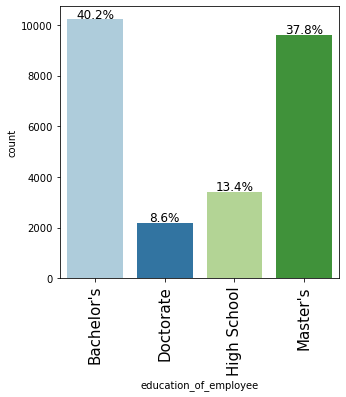

In [32]:
#Observations on education
labeled_barplot(data, "education_of_employee", perc=True)

- Majority of employees have either a bachelor's (40%) or a master's (38%) and minority of applicants have either a doctorate (8%) or only a high school diploma (13%)

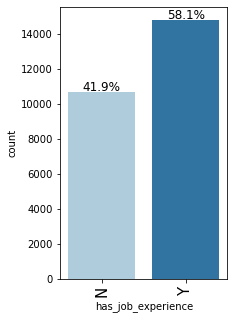

In [33]:
#Observations on job_experience
labeled_barplot(data, "has_job_experience", perc=True)

- Around 58% employees have prior job experience and 42% employees do not

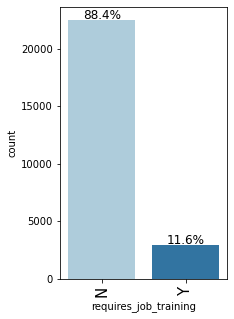

In [34]:
#Observations on requires_training
labeled_barplot(data, "requires_job_training", perc=True)

- Majority do not require job training (88%). Although we observed that only 58% had prior job experience. It is possible that some occupations require employees with no prior job experience

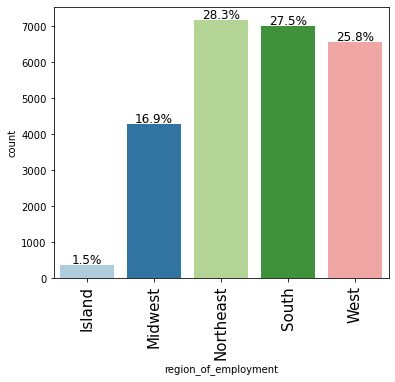

In [35]:
#Observations on region_of_employment 
labeled_barplot(data, "region_of_employment", perc=True)

- Northeast, South and West equally have employment opportunities with Human Resource shortages with 25-28% employees applying for visa approval to these regions, followed by Midwest (18%) and Island (1.5%)

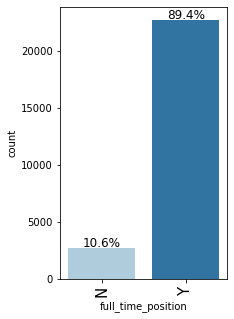

In [36]:
#Observations on full_time_position
labeled_barplot(data, "full_time_position", perc=True)

- 88% are full time positions

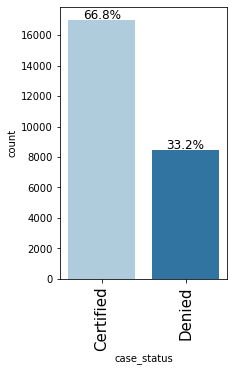

In [37]:
#Observations on case_status
labeled_barplot(data, "case_status", perc=True)

- Approximately, 67% cases are approved and 33% cases are denied

### Bivariate analysis and data preprocessing 

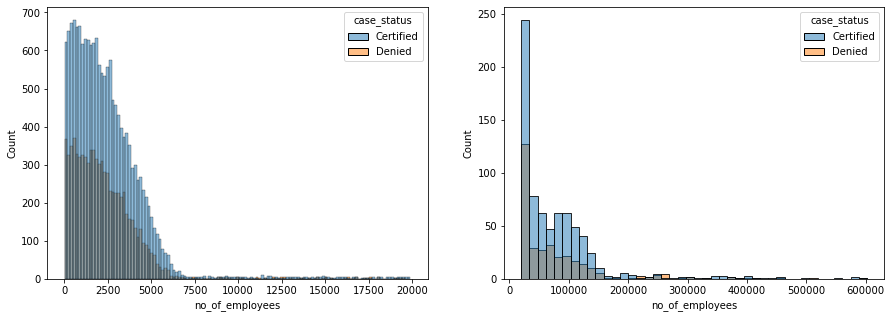

In [38]:
#number of employees and case status
fig,ax=plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=data[data["no_of_employees"]<20000], x="no_of_employees", hue="case_status", ax=ax[0]);
sns.histplot(data=data[data["no_of_employees"]>20000], x="no_of_employees", hue="case_status", ax=ax[1]);

- Greater than twice the number of cases are certified than denied both for employers having lesser as well as more number of employees. 
- The large number of outliers in attribute will require further treatment. Although, the ML model is based on decision trees, which optimizes & splits(bins) the data by default, we can choose to bin the continuous datapoints into 3 practically chosen bins to decrease the model building time. This is because from the EDA, we see no spcific relationship between cases being certified and no_of_employees in an organization.  

In [39]:
data["no_of_employees"] = pd.cut( data["no_of_employees"], \
                                  [0, 2500, 7500, np.inf], \
                                  labels = ["Small_Sized(<2500employees)", \
                                            "Medium_Sized(2500-7500employees)", \
                                            "Large_Sized(>75000employees)"])
data["no_of_employees"] = data["no_of_employees"].astype("category")

In [40]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

case_status                       Certified  Denied    All
no_of_employees                                           
All                                   17001    8446  25447
Small_Sized(<2500employees)            9674    5084  14758
Medium_Sized(2500-7500employees)       6272    2874   9146
Large_Sized(>75000employees)           1055     488   1543
------------------------------------------------------------------------------------------------------------------------


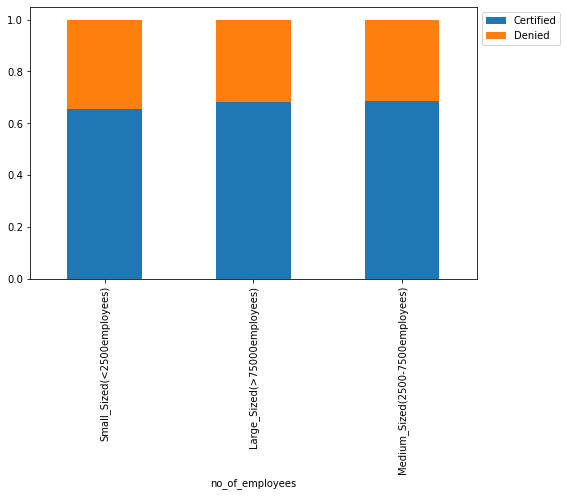

In [41]:
stacked_barplot(data, "no_of_employees", "case_status")

- The information is retained after binning. >65% of cases in all categories are certified
- 58% are small sized companies (less than 2500 employees), 36% are medium_sized and 6% are larege sized companies (more than 7500 employees)

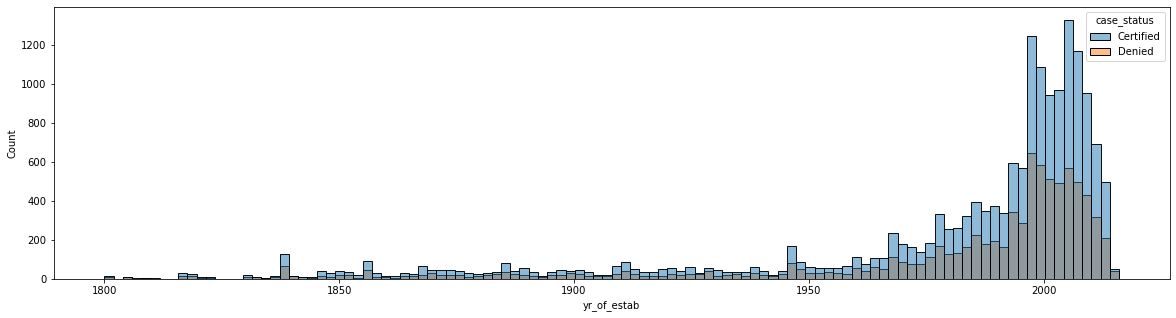

In [42]:
#year of establishment and case_status
plt.figure(figsize=(20,5))
sns.histplot(data, x="yr_of_estab", hue="case_status");

- Similar to before, slightly more than 50% of all cases are certified than denied for employers irrespective of the employer's year of establishment 
- There are a large number of lower ended outliers, which will be binned likewise -

In [43]:
data["yr_of_estab"] = pd.cut( data["yr_of_estab"], \
                                  [-np.inf, 1990, np.inf], \
                                  labels = ["Older_Estab(1800-1990)", \
                                            "Newer_Estab(>1990)"])
data["yr_of_estab"] = data["yr_of_estab"].astype("category")

case_status             Certified  Denied    All
yr_of_estab                                     
All                         17001    8446  25447
Newer_Estab(>1990)          10427    5083  15510
Older_Estab(1800-1990)       6574    3363   9937
------------------------------------------------------------------------------------------------------------------------


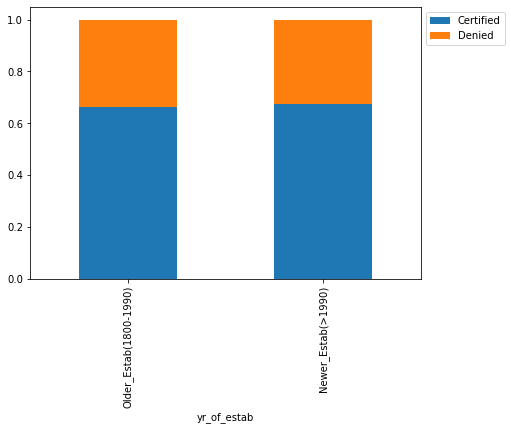

In [44]:
stacked_barplot(data, "yr_of_estab", "case_status")

- The information is retained after binning. >65% of cases in both categories are approved
- Around 61% of employers were established after 1990 and 39% of employers before 1990

case_status   Certified  Denied    All
unit_of_wage                          
All               17001    8446  25447
Not_Hourly        16254    7040  23294
Hourly              747    1406   2153
------------------------------------------------------------------------------------------------------------------------


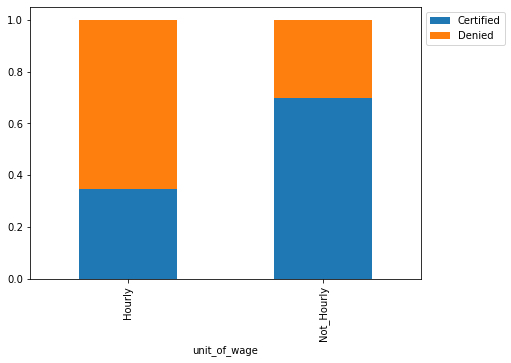

In [45]:
stacked_barplot(data, "unit_of_wage", "case_status")

- Almost 70% of cases are certified when the unit_of_wage is not hourly, and only 35% cases are certified when the unit_of_wage is hourly

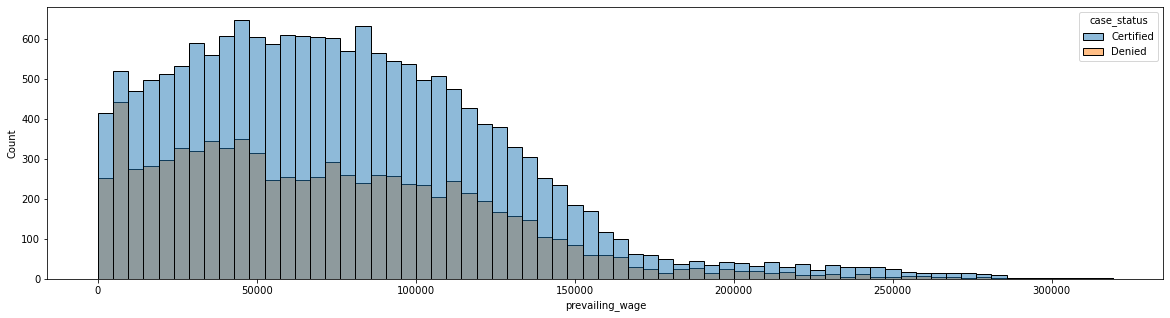

In [46]:
#prevailing_wage and case_status

plt.figure(figsize=(20,5))
sns.histplot(data, x="prevailing_wage", hue="case_status");

- There are some outliers on the lower end (USD 14,500 or less annually) which are worrying. These may reference either positions that are unskilled or where tips received make up portion of the compensation. Similarly, there are outliers on the higher end (USD 200,000 or more annually) which reference highly skilled positions. We see a general trend that ~ twice the cases are certified more than denied. 
- % certifications in comparison to % denied drops slightly on the lower end of the prevailing_wage and increases slightly on the upper end of the prevailing_wage
- The number of outliers are not as high as in the previous two instances (no_of_employees & yr_of_estab), as decision trees are immune to outliers, this has not been treated further. As well, above a certain income threshold & below a certain treshold, EDA indicates, similar response for case statuses

case_status    Certified  Denied    All
continent                              
All                17001    8446  25447
Asia               11001    5839  16840
North America       2037    1250   3287
Europe              2953     774   3727
South America        492     359    851
Africa               396     154    550
Oceania              122      70    192
------------------------------------------------------------------------------------------------------------------------


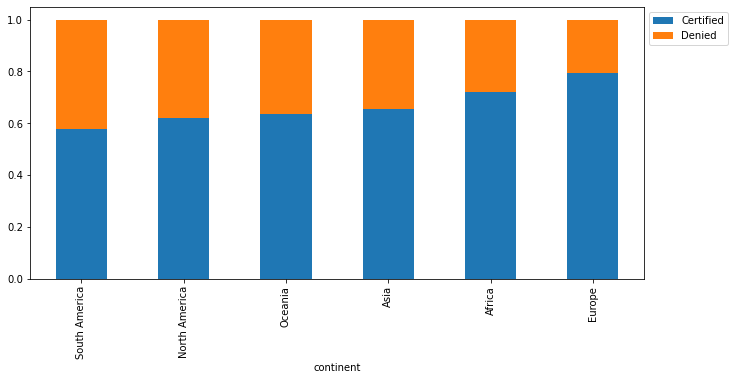

In [47]:
#continent and case status
stacked_barplot(data, "continent", "case_status")

- Irrespective of the continent the employee is from, more cases are certified than denied
- The trend observed w.r.t % certification for continents is Europe > Africa > Asia > Oceania > North America & South America 

case_status            Certified  Denied    All
education_of_employee                          
All                        17001    8446  25447
Bachelor's                  6362    3858  10220
High School                 1164    2252   3416
Master's                    7565    2057   9622
Doctorate                   1910     279   2189
------------------------------------------------------------------------------------------------------------------------


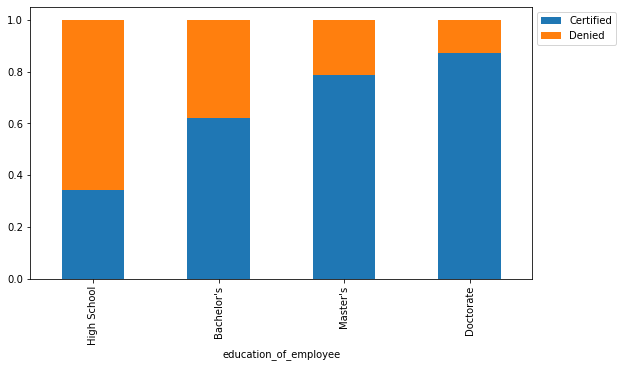

In [48]:
#education and case status
stacked_barplot(data, "education_of_employee", "case_status")

- As expected the, the trend observed w.r.t % visa certification for education of employees is Doctorate > Master's > Bachelor's > High School 

case_status         Certified  Denied    All
has_job_experience                          
All                     17001    8446  25447
N                        5986    4675  10661
Y                       11015    3771  14786
------------------------------------------------------------------------------------------------------------------------


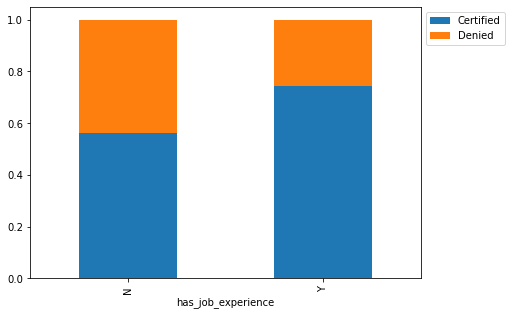

In [49]:
#job_experience and case status
stacked_barplot(data, "has_job_experience", "case_status")

- As expected, the trend observed w.r.t % visa certifications for has_job_experience is Yes > No

case_status            Certified  Denied    All
requires_job_training                          
All                        17001    8446  25447
N                          15000    7498  22498
Y                           2001     948   2949
------------------------------------------------------------------------------------------------------------------------


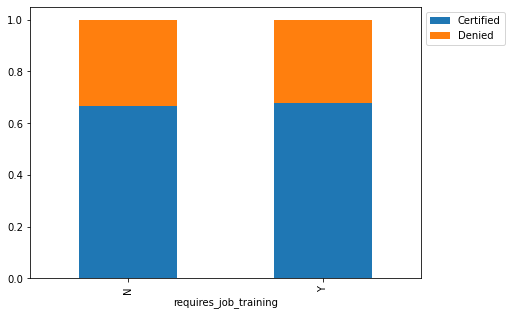

In [50]:
#requires_job_training and case status
stacked_barplot(data, "requires_job_training", "case_status")

Trend observed w.r.t. % visa certifications for requires_job_training is same Yes ~ No 

case_status           Certified  Denied    All
region_of_employment                          
All                       17001    8446  25447
Northeast                  4524    2665   7189
West                       4097    2481   6578
South                      4908    2098   7006
Midwest                    3246    1053   4299
Island                      226     149    375
------------------------------------------------------------------------------------------------------------------------


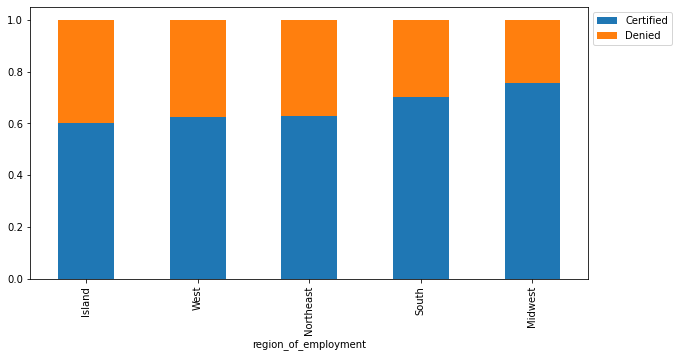

In [51]:
#region_of_employment and case status
stacked_barplot(data, "region_of_employment", "case_status")

- Trend observed w.r.t visa certifications for region_of_employment is MidWest > South > Northeast ~ West > Island 

case_status         Certified  Denied    All
full_time_position                          
All                     17001    8446  25447
Y                       15146    7595  22741
N                        1855     851   2706
------------------------------------------------------------------------------------------------------------------------


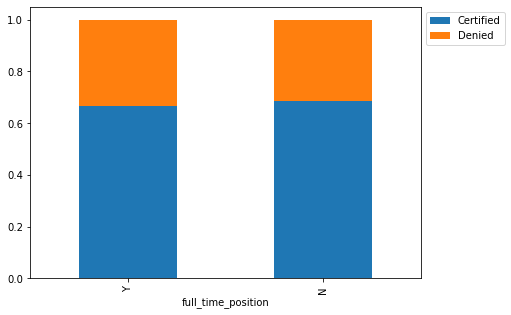

In [52]:
#full_time_position and case status
stacked_barplot(data, "full_time_position", "case_status")

Trend observed w.r.t. % visa certifications for full_time_position is same Yes ~ No 

### EDA Sumamrized 

- More than twice the number of cases were certified than denied irrespective of the number of employees in the employer's organization & the year of establishment of the employer's organization. These attributes are hence, not thought to have an impact on case statuses 
   - Both these attrtibutes are heavily skewed, the no_of_employees is skewed right but yr_of_estab is skewed left
   - From the EDA, we infer 58% of all cases were for smaller organizations (<2500 employees) and 61% of all cases were for employer's established after 1990
  
  
- Only 35% of the cases were certified when the unit_of_wage is Hour-ly but 70% were certified when the unit_of_wage are not Hour-ly (i.e, Week-ly, Month-ly or Year-ly). This indicates unit_of_wage is an important attribute that can influence case statuses
  - From the EDA, we infer only 8.5% of all cases were for unit_of_wage Hour-ly and the remaining 91.5% of all cases were for unit_of_wage not Hour-ly (i.e, Week-ly, Month-ly or Year-ly)
    
    
- Majority of cases are from applicants in Asia (66%), then Europe (15%), N.America (13%) & S.America (3%); however, cases getting certified is highest for Europe (80% of such cases), then Africa (72% of such cases), then Asia (65% of such cases), .. & least for S.America & N.America (around 60% of such cases). More cases are certified than denied irrespective of the continent. Being from Europe is though to be an important attribute to have an impact on case statuses


- Majority of applicants have a bachelor's (40%) or a master's degree (37.87%). A small number have only high school certification (13.4%) or are very highly educated/ doctorate (8.6%). However, cases getting certified is highest for doctorate degree (>86%),followed by master degree (>76%), then bachelor's (~62%). The cases getting certified is very low for those applicants with only a high school certification (<35%). The trend observed is intuitive and one can expect attributes having a doctorate degress & having only a high school certification to significantly contribute to a case being certified and denied respectively


- From the EDA, we infer that 58% of all applicants have prior job experience and 42% do not. The cases getting certified is high for applicants with prior job experience (75% of such cases) and low for applicants without prior job experience (~56% of such cases). This is again an important attribute with an applicant having prior job experience significantly contributing to a case being certified


- Majority do not require the employee to receive any additional job training. This attribute was not found to have an impact on the case statuses


- Majority of the applications are to Northeast (28.3%), then South (27.5%), then West (25.8%), Midwest (16.9%) and least to Island (1.5%) regions of the US. However, the cases certified follows the trend Midwest (75% of such cases), then South (70% of such cases), then Northeast, West, & Island (60% of such cases). Region of employment being Midwest hence is an important attribute contributing positively to a case being certified


- Majority of the jobs are full time rather than part time. This attribute was not found to have an impact on the case statuses

### Split the dataset

In [53]:
data["case_status"] = data["case_status"].apply(lambda x: 0 if x == "Denied" else 1)

In [54]:
#Separating features and the target column
X = data.drop("case_status", axis=1)
y = data["case_status"]

In [55]:
X = pd.get_dummies(X, drop_first=True)

In [56]:
#Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

In [57]:
X_train.shape, X_test.shape

((17812, 20), (7635, 20))

- We have 17,812 and 7,635 rows in the train and test datasets

In [58]:
y.value_counts(1)

1    0.668094
0    0.331906
Name: case_status, dtype: float64

In [59]:
y_train.value_counts(1)

1    0.668089
0    0.331911
Name: case_status, dtype: float64

In [60]:
y_test.value_counts(1)

1    0.668107
0    0.331893
Name: case_status, dtype: float64

- Stratify has maintained the distribution of classes when splitting to a train and test dataset

### Model evaluation criterion

The model can make wrong predictions as:
   - Certifying a case when the required criteria are not met
   - Denying a case when the required criteria are met

### Which case is more important? 
   - If cases where criteria are not met are certified, it could have an adverse impact leading to job loss for citizens and locals in the US as well, the foreign workers will be hired at less than ideal pay for market rate & their calibre
   - If cases are denied where criteria are met, it could also have an adverse impact leading to human resource shortages across occupations in the US, slowing down the economy

### Which metric to optimize?
   - We would want F1-Score to be maximized, the greater the F1-Score higher the chances of predicting both the classes correctly

#### Functions to calculate performance metrics and create confusion matrix for different models

In [61]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [62]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Decision Tree Classifier

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.661559  0.743384   0.748372  0.745869


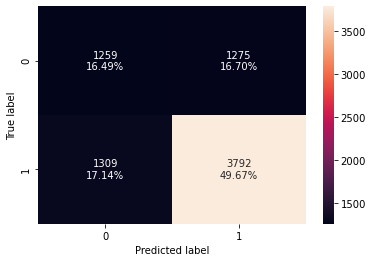

In [63]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

- The decision tree is overfitting the training data. Training metrics are high but the testing metrics are not. F1_score for the test set is only 0.75. We can improve model performance by hyperparameter tuning 

### Decision Tree - Hyperparameter tuning

In [64]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.668,1:0.332},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.668, 1: 0.332}, max_depth=2,
                       max_leaf_nodes=2, min_impurity_decrease=0.0001,
                       random_state=1)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.711599  0.932605   0.719108  0.812059
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.709103  0.929034   0.718248  0.810155


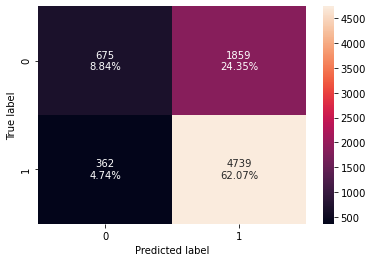

In [65]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

- The hyperparameter tuned decision tree is not overfiting the dataset, as well the F1 score has improved. F1 score for both the train and test datasets are 0.812 & 0.810 respectively

### Random Forest Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.999832  0.999916   0.999832  0.999874
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.676621  0.760047   0.756931  0.758486


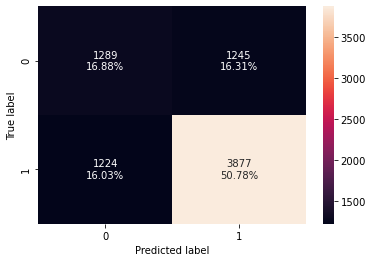

In [66]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

- Random forest model is also overfitting the training data

### Random Forest - Hyperparameter tuning

In [67]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.668,1:0.332},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(10,30,10)) + [None],
                'max_features': ['sqrt',None],
                'min_samples_leaf': np.arange(5,15,5),
                'min_samples_split': np.arange(5, 20, 5),
                'n_estimators': np.arange(20,120,40)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.668, 1: 0.332}, max_depth=10,
                       max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=15, oob_score=True, random_state=1)

Training performance:
    Accuracy   Recall  Precision       F1
0  0.745789  0.77958   0.829637  0.80383
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.724951  0.761419   0.814768  0.787191


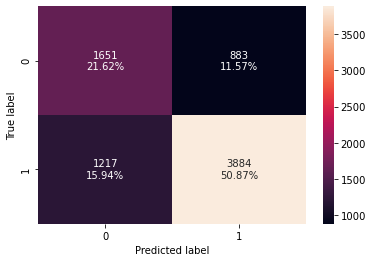

In [68]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

- Hyperparameter tuning has decreased the overfit and increased F1 score, however, this model is not performing as optimally as the hyperparameter tuned decision tree

### Bagging Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.977824  0.978655   0.988038  0.983324
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.688016  0.757106   0.771628  0.764298


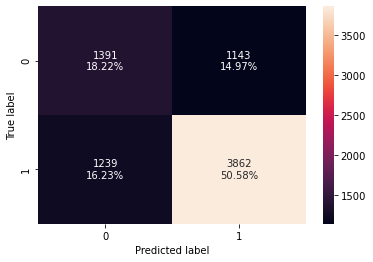

In [69]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print("Training performance:\n", bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print("Testing performance:\n", bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

- Bagging classifier is also overfiting the training data

### Bagging - Hyperparameter Tuning

In [70]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.7, max_samples=0.7, n_estimators=50,
                  random_state=1)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.956041  0.993697   0.943509  0.967953
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.728225  0.877475   0.755316  0.811826


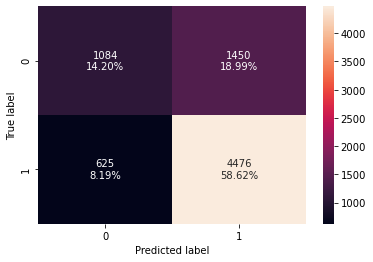

In [71]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print("Training performance:\n", bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print("Testing performance:\n", bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

- The model is still found to overfit the training data, as the training metrics are high but the testing metrics are not

### AdaBoost Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.738322  0.888151   0.760414  0.819334
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.73556  0.877671   0.762432  0.816003


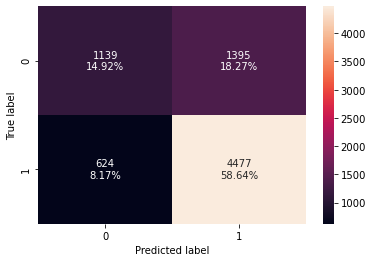

In [72]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print("Training performance:\n", ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print("Testing performance:\n", ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

- Unlike the decision tree, random forest, or the bagging classifier; the AdaBoost classifier is not found to overfit the training data. It is giving a generalized performance on the training & testing data with a F1 score 0.819 & 0.816 

### AdaBoost - Hyperparamter tuning

In [73]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1),
                      DecisionTreeClassifier(max_depth=2)],
    "n_estimators": np.arange(20,120,40),
    "learning_rate":np.arange(0.2,2,0.6)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=3)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.2, n_estimators=60, random_state=1)

Training performance:
    Accuracy    Recall  Precision        F1
0   0.74927  0.870252   0.779937  0.822623
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.745514  0.861596   0.780362  0.81897


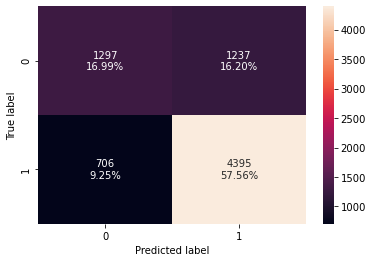

In [74]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print("Training performance:\n", abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print("Testing performance:\n", abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

- The hyperparameter tuned model is giving similar performance to the default AdaBoost model

### Gradient Boosting Classifier 

Training performance:
    Accuracy    Recall  Precision        F1
0  0.755839  0.875882   0.783979  0.827386
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.748527  0.865517   0.781554  0.821395


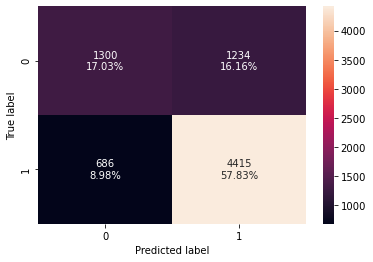

In [75]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

- The gradient boosting model is giving generalized performance on both the training and testing data with very high F1 scores of 0.827 and 0.821 respectively

### Gradient Boosting - Hyperparameter Tuning

In [76]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,175,250],
    "subsample":[0.8,1],
    "max_features":[0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=3)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.8, random_state=1, subsample=0.8)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.754379  0.876134   0.782322  0.826575
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.746431  0.865321   0.779446  0.820141


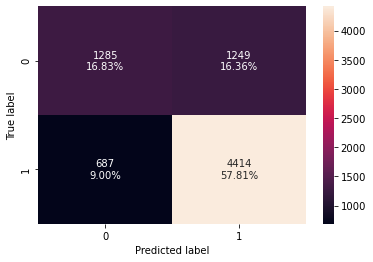

In [77]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

- There is not much difference in the model performance after hyperparameter tuning

### XGBoost Classifier

Training performance:
    Accuracy    Recall  Precision      F1
0  0.809903  0.914706   0.821138  0.8654
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.737525  0.858851   0.773345  0.813858


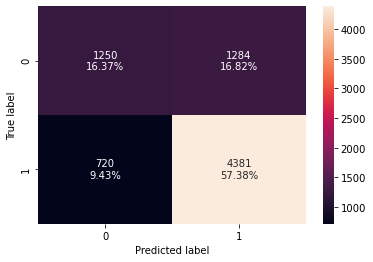

In [78]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

- The XGBoost classifier is slightly overfitting the training data

### XGBoost - Hyperparameter tuning

In [79]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=3)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=4,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.753818  0.898739   0.770811  0.829874
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.746955  0.887473   0.769244  0.82414


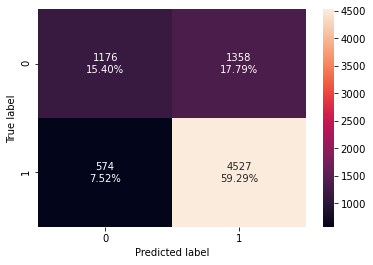

In [80]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

- The overfitting has reduced & the model is giving generalized performance on both training & testing data. F1 scores are high with 0.829 and 0.8214 for the training & testing datasets

### Stacking Classifier

In [81]:
estimators = [('Ad Boost Tuned',abc_tuned), ('Gradient Boost Tuned',gbc_tuned), ('Decision Tree Tuned',dtree_estimator)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(estimators=[('Ad Boost Tuned',
                                AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                                   learning_rate=0.2,
                                                   n_estimators=60,
                                                   random_state=1)),
                               ('Gradient Boost Tuned',
                                GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                                           max_features=0.8,
                                                           random_state=1,
                                                           subsample=0.8)),
                               ('Decision Tree Tuned',
                                DecisionTreeClassifier(c...
                                                 eval_metric='logloss', gamma=0,
                                                 gpu_id=-1,


Training performance:
    Accuracy    Recall  Precision        F1
0  0.753649  0.878655   0.780299  0.826561
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.745907  0.866301   0.778404  0.820004


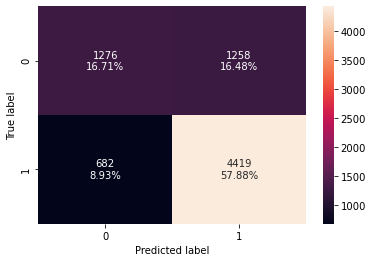

In [82]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

- The metrics are similar to what has been observed with other models post hyperparameter tuning. The model is not overfitting & gives generalized performance with training & testing F1 scores of 0.826 & 0.820
- The model is able to identify the majority of cases that should be certified correctlly, but not as many cases that should be denied correctly

### Comparing all models

In [83]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.711599,0.999832,0.745789,0.977824,0.956041,0.738322,0.749270,0.755839,0.754379,0.809903,0.753818,0.753649
Recall,1.0,0.932605,0.999916,0.779580,0.978655,0.993697,0.888151,0.870252,0.875882,0.876134,0.914706,0.898739,0.878655
Precision,1.0,0.719108,0.999832,0.829637,0.988038,0.943509,0.760414,0.779937,0.783979,0.782322,0.821138,0.770811,0.780299
F1,1.0,0.812059,0.999874,0.803830,0.983324,0.967953,0.819334,0.822623,0.827386,0.826575,0.865400,0.829874,0.826561


In [84]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.661559,0.709103,0.676621,0.724951,0.688016,0.728225,0.735560,0.745514,0.748527,0.746431,0.737525,0.746955,0.745907
Recall,0.743384,0.929034,0.760047,0.761419,0.757106,0.877475,0.877671,0.861596,0.865517,0.865321,0.858851,0.887473,0.866301
Precision,0.748372,0.718248,0.756931,0.814768,0.771628,0.755316,0.762432,0.780362,0.781554,0.779446,0.773345,0.769244,0.778404
F1,0.745869,0.810155,0.758486,0.787191,0.764298,0.811826,0.816003,0.818970,0.821395,0.820141,0.813858,0.824140,0.820004


- Decision tree, Random forest (default & tuned), Bagging classifier (default & tuned) & XGBoost were found to overfit the training dataset
- Decision tree tuned, Adaboost (default & tuned), Gradient boost (default & tuned) and XGBoost (tuned) were found to give generalized performance on the training & testing data sets. Of these, the XGBoost (tuned)  has the highest F1 score (although all models have more or less similar performance)

### Feature importance of XGBoost Hyperparameter Tuned Model

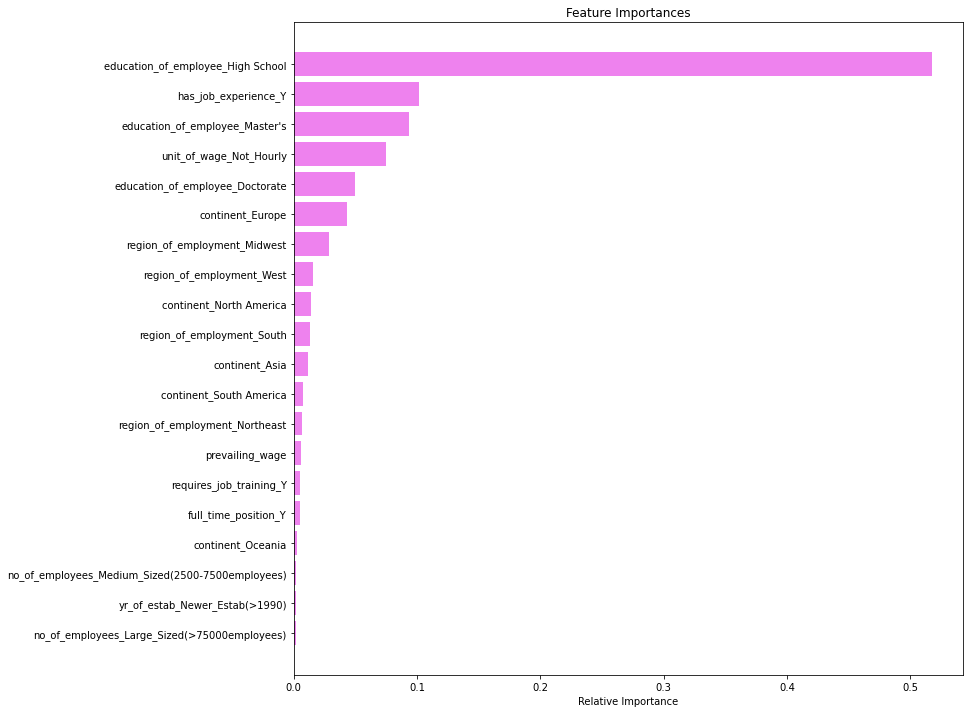

In [88]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- The findings from the optimized model is similar to what was observed post EDA
- Education of the employee was found to be the most important attribute having an influence on visa certifications. Other important attributes found were - if an employee has prior job experience, unit_of_wage, continent of the employee, & region of employment in the US

## Actionable Insights and Recommendations

- Based on the EDA and the XGBoost(tuned) model, the following features were identified as important for visas getting certified than denied
     - (1) Education of employee ; an employee with only a high school certififcation has over 65% chance of visa getting denied in comparison to an employee with a doctorate degree with over a 85% chance of visa getting certified
     - (2) Unit of wage ; an employee with an hourly pay likewise has over 65% chance of visa getting denied in comparison to an employee with a non-hourly pay (week-ly, month-ly or year-ly) with over 70% chance of visa getting certified
     - (3) The continent the employee is from (e.g., if Europe, over 80% chance of visa getting certified), if the employee has prior job experience (over 75% chance of visa getting approved if an employee has prior work experience but 50% chance of visa getting denied if an employee has no work experience) are other important attributes
     - (4) Likewise, the region of the US the employment opportunity is in is also an important deciding factor with over 70% cases getting certified if the region is Midwest or South
     
     
- Interestingly, attributes like if the job opportunity is full time/ part time ; if an employee requires further job training ; the annual prevailing wage of the occupation in the US ; year of establishment of the employer or the number of employees in the organization are not important attributes & do not have much bearing on a case getting certified vs denied


- The XGBoost hyperparameter tuned ML model is able to give generalized prediction on training & testing datasets (not prone to overfitting) and is able to explain over 80% of information (accuracy of 75% on test dataset & F1 score of 82% on test dataset). 
     - The precision & recall are likewise both high (77% & 88% respectively)
     - The confusion matrix is able to identify a higher % of cases getting certified, but only a smaller % of cases getting denied correctly. This limitation has to be borne in mind, and perhaps a reevaluation of cases getting denied can be carried out in case there is a a prevailing human resource shortage in the US. The model is still helpful, as only a small subset of data will need further re evaluation significantly decreases time spent in the process